Weakly coupled Co-simulation
================

This guides shows how to implement a simplified weakly-coupled co-simulation in emtsim

Test circuit
--------------------

As a first simple, test we will simulate a small static network. The network consists of 4 nodes and 4 elements:

| Component | Type              | Python Class                              | Node A | Node B | Paramter |
| :---------| :----             | :---------------------------------------- | :----- | :----- | :------- |
| r_1       | Source resistance | `dpsimpy.emt.ph1.Resistor`                 | 0      | GND    | 0.1 Ohm  |
| c_1       | Line capacitance  | `dpsimpy.emt.ph1.Capacitor`                | 0      | GND    | 1 Farad  |
| c_2       | Line capacitance  | `dpsimpy.emt.ph1.Capacitor`                | 1      | GND    | 1 Farad  |
| r_line    | Line resistance   | `dpsimpy.emt.ph1.Resistor`                 | 1      | 0      | 0.1 Ohm  |
| r_load    | Load              | `dpsimpy.emt.ph1.Resistor`                 | 1      | GND    | 1 Ohm    |

Before we can start, we must import the DPsim Python module.
We also add `emt` as an alias for the dynamic phasor components.

In [10]:
import dpsimpy
import numpy as np

Next, we can define the model by creating a couple of components.
Each component is identified by a name which is passed as the first argument.
Following arguments are used to define the topology by assigning the component to a specific node / bus or to pass parameters.

In [12]:
num_vs = 0

# Nodes
gnd = dpsimpy.emt.SimNode.gnd

if num_vs > 0:
    n0 = dpsimpy.emt.SimNode("n0")
    
if num_vs > 1:
    n3 = dpsimpy.emt.SimNode("n3")

n1  = dpsimpy.emt.SimNode("n1")
n2  = dpsimpy.emt.SimNode("n2")

if num_vs > 0:
    v_s_1 = dpsimpy.emt.ph1.VoltageSource("v_s_1")
    if num_vs == 1:
        v_s_1.set_parameters(V_ref=complex(1, 0), f_src=50)
    else:
        v_s_1.set_parameters(V_ref=complex(2, 0), f_src=50)

if num_vs > 1:
    v_s_2 = dpsimpy.emt.ph1.VoltageSource("v_s_2")
    v_s_2.set_parameters(V_ref=complex(np.sqrt(2)/2, np.sqrt(2)/2), f_src=50)        

r_1 = dpsimpy.emt.ph1.Resistor("r_1", dpsimpy.LogLevel.info)
r_1.R = 0.1
r_line = dpsimpy.emt.ph1.Resistor("r_line", dpsimpy.LogLevel.info)
r_line.R = 0.1
c_1 = dpsimpy.emt.ph1.Capacitor("c_1", dpsimpy.LogLevel.info)
c_1.C = 1
c_2 = dpsimpy.emt.ph1.Capacitor("c_2", dpsimpy.LogLevel.info)
c_2.C = 1
r_load = dpsimpy.emt.ph1.Resistor("r_load", dpsimpy.LogLevel.info)
r_load.R = 1

# Initial conditions
if num_vs > 0:
    n1.set_initial_voltage(0 * dpsimpy.PEAK1PH_TO_RMS3PH)
    n2.set_initial_voltage(0 * dpsimpy.PEAK1PH_TO_RMS3PH)
else:
    n1.set_initial_voltage(5 * dpsimpy.PEAK1PH_TO_RMS3PH)
    n2.set_initial_voltage(2 * dpsimpy.PEAK1PH_TO_RMS3PH)

# Connections
if num_vs > 0:
    v_s_1.connect([gnd, n0])
    r_1.connect([n0, n1])     
else:
    r_1.connect([n1, gnd])

if num_vs > 1:
    v_s_2.connect([gnd, n3])
    r_load.connect([n2, n3])
else:
    r_load.connect([n2, gnd])
    
r_line.connect([n2, n1])
c_1.connect([n1, gnd])
c_2.connect([n2, gnd])

Next, we have to create a simulation object:

In [13]:
if num_vs == 1:
    sys = dpsimpy.SystemTopology(50, [ gnd, n0, n1, n2 ], [ v_s_1, r_1, r_line, c_1, c_2, r_load ])
elif num_vs == 2:
    sys = dpsimpy.SystemTopology(50, [ gnd, n0, n1, n2, n3 ], [ v_s_1, r_1, r_line, c_1, c_2, r_load, v_s_2 ])
else:
    sys = dpsimpy.SystemTopology(50, [ gnd, n1, n2 ], [ r_1, r_line, c_1, c_2, r_load ])

We can also visualize the system topology:

In [ ]:
sys

Finally, we can start the simulation and wait for its completion:

In [14]:
time_step = 50e-6
final_time = 1.2

# time_step = 0.001
# final_time = 1.0

sim = dpsimpy.Simulation("EMTCosim", loglevel=dpsimpy.LogLevel.debug)
sim.set_domain(dpsimpy.Domain.EMT)
sim.set_system(sys)
sim.set_time_step(time_step)
sim.set_final_time(final_time)

log = dpsimpy.Logger("EMTCosim")

if num_vs > 0:
    log.log_attribute("v0", "v", sys.node("n0"))
    if num_vs > 1:
        log.log_attribute("v3", "v", sys.node("n3"))
log.log_attribute("v1", "v", sys.node("n1"))
log.log_attribute("v2", "v", sys.node("n2"))
log.log_attribute("r_line.I", "i_intf", sys.component("r_line"))

sim.add_logger(log)
    
sim.run()

[11:58:48.977935 EMTCosim info] Initialize simulation: EMTCosim
[11:58:48.978268 MnaSolverFactory info] creating KLUAdapter solver implementation
[11:58:48.981229 EMTCosim info] Scheduling tasks.
[11:58:48.981925 EMTCosim info] Scheduling done.
[11:58:48.981935 EMTCosim info] Opening interfaces.
[11:58:48.981936 EMTCosim info] Start synchronization with remotes on interfaces
[11:58:48.981937 EMTCosim info] Synchronized simulation start with remotes
[11:58:48.981939 EMTCosim info] Start simulation: EMTCosim
[11:58:48.981944 EMTCosim info] Time step: 5.000000e-05
[11:58:48.981946 EMTCosim info] Final time: 1.200000e+00
[11:58:49.255211 EMTCosim info] Simulation calculation time: 0.273178
[11:58:49.255664 EMTCosim info] Simulation finished.


Next, we run the co-simulation

In [2]:
import subprocess
import numpy as np

H_v = np.array([1e-4, 2e-4, 4e-4, 0.001, 0.003, 0.01])
H_v_legends = ['1e-4', '2e-4', '4e-4', '1e-3', '3e-3', '1e-2']
# H_v = [0.2e-3]
# H_v_legends = ['0.2e-3']

# H_v = [1e-4]
# H_v_legends = ['1e-4']

# H_v = [0.003]
# H_v_legends = ['0.003']

# Consistent initial conditions for linear extrapolation and num_vs = 0
y_1_prev_H = [30.1080, 30.216, 30.432, 31.08, 33.24, 40.8]
# y_1_prev_H = [0, 0, 0, 0, 0, 0]

In [ ]:
# This here is for evaluating the trapezoidal method error against Matlab
# i=0
# for time_step_mono in H_v:
#     sim = dpsimpy.Simulation("EMTCosim_" + H_v_legends[i], loglevel=dpsimpy.LogLevel.debug)
#     sim.set_domain(dpsimpy.Domain.EMT)
#     sim.set_system(sys)
#     sim.set_time_step(time_step_mono)
#     sim.set_final_time(final_time)

#     log = dpsimpy.Logger("EMTCosim_" + H_v_legends[i])

#     if num_vs > 0:
#         log.log_attribute("v0", "v", sys.node("n0"))
#         if num_vs > 1:
#             log.log_attribute("v3", "v", sys.node("n3"))
#     log.log_attribute("v1", "v", sys.node("n1"))
#     log.log_attribute("v2", "v", sys.node("n2"))
#     log.log_attribute("r_line.I", "i_intf", sys.component("r_line"))

#     sim.add_logger(log)
        
#     sim.run()

#     i+=1


In [ ]:
i=0
for H in H_v:
    m = int(H/time_step)
    print(m)

    process1 = subprocess.Popen(["python3", "../../Python/Attributes/emt-cosim-attributes_polynomial.py", "-t", str(time_step), "-e", str(final_time), "-H", str(H), "-m", "extrapolation-zoh", "-p", "EMTCosimAttributes_zoh_" + H_v_legends[i], "--num-vs", str(num_vs)], stdout=subprocess.PIPE, stderr=subprocess.STDOUT)
    output1, error1 = process1.communicate()
    process2 = subprocess.Popen(["python3", "../../Python/Attributes/emt-cosim-attributes_polynomial.py", "-t", str(time_step), "-e", str(final_time), "-H", str(H), "-m", "extrapolation-linear", "--y1-prev", str(y_1_prev_H[i]), "-p", "EMTCosimAttributes_linear_" + H_v_legends[i], "--num-vs", str(num_vs)], stdout=subprocess.PIPE, stderr=subprocess.STDOUT)
    output2, error2 = process2.communicate()
    # process3 = subprocess.Popen(["python3", "../../Python/Attributes/emt-cosim-attributes_polynomial.py", "-t", str(time_step), "-e", str(final_time), "-H", str(H), "-m", "none", "-p", "EMTCosimAttributes_no_extrap_" + H_v_legends[i], "--num-vs", str(num_vs)], stdout=subprocess.PIPE, stderr=subprocess.STDOUT)
    # output3, error3 = process3.communicate()
    process3 = subprocess.Popen(["python3", "../../Python/Attributes/emt-cosim-attributes_polynomial.py", "-t", str(time_step), "-e", str(final_time), "-H", str(H), "-m", "delay", "-p", "EMTCosimAttributes_delay_" + H_v_legends[i], "--num-vs", str(num_vs)], stdout=subprocess.PIPE, stderr=subprocess.STDOUT)
    output3, error3 = process3.communicate()

    # Print output and error for debugging
    print("Output 1:", output1)
    print("Error 1:", error1)
    print("Output 2:", output2)
    print("Error 2:", error2)
    print("Output 3:", output3)
    print("Error 3:", error3)

    # Check return codes
    # assert process1.returncode == 0, f"Subprocess 1 failed for H = {H}"
    # assert process2.returncode == 0, f"Subprocess 2 failed for H = {H}"

    i+=1

# TODO: Verify why the villas co-simulation does not log outputs correctly using Popen
# process = subprocess.Popen(["python3", "../villas/emt-cosim-villas.py"], stdout=subprocess.PIPE, stderr=subprocess.PIPE, text=True)

Results can be analyzed and plotted by the `villas.dataprocessing` package:

column number: 3
results length: 24001
real column names: ['r_line.I', 'v1', 'v2']
complex column names: []
column number: 6
results length: 24001
real column names: ['i_intf', 'i_r_line', 'v_1', 'v_2', 'v_intf']
complex column names: ['v_ref']
column number: 6
results length: 24001
real column names: ['i_intf', 'i_r_line', 'v_1', 'v_2', 'v_intf']
complex column names: ['v_ref']
column number: 6
results length: 24001
real column names: ['i_intf', 'i_r_line', 'v_1', 'v_2', 'v_intf']
complex column names: ['v_ref']
column number: 6
results length: 24001
real column names: ['i_intf', 'i_r_line', 'v_1', 'v_2', 'v_intf']
complex column names: ['v_ref']
column number: 6
results length: 24001
real column names: ['i_intf', 'i_r_line', 'v_1', 'v_2', 'v_intf']
complex column names: ['v_ref']
column number: 6
results length: 24001
real column names: ['i_intf', 'i_r_line', 'v_1', 'v_2', 'v_intf']
complex column names: ['v_ref']
column number: 4
results length: 24001
real column names: ['i_intf', '

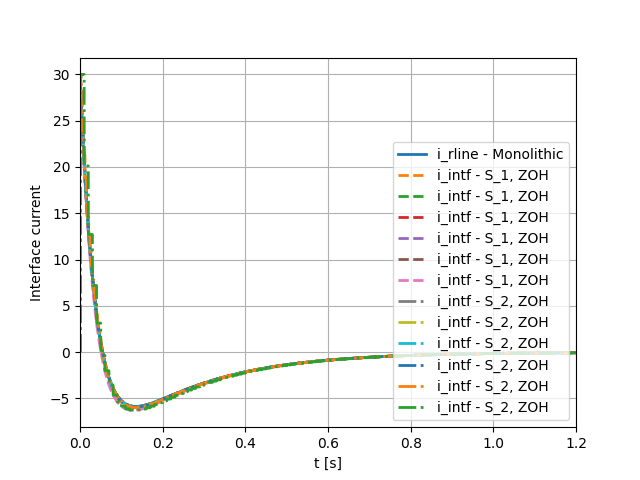

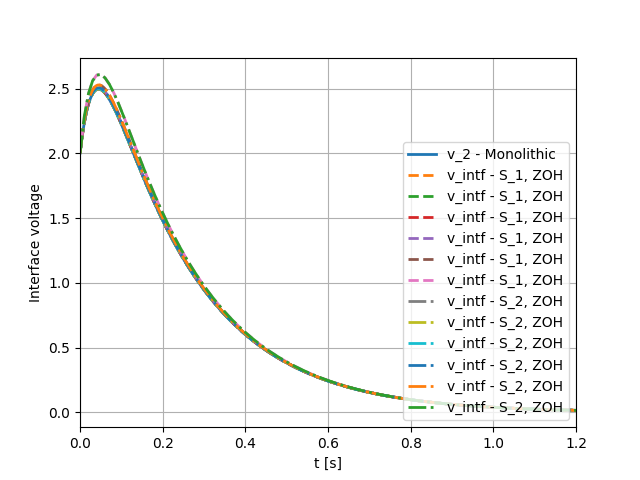

In [3]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
%config InlineBackend.rc = {'font.size': 10, 'figure.figsize': (6.0, 4.0), 'figure.facecolor': 'white', 'savefig.dpi': 72, 'figure.subplot.bottom': 0.125, 'figure.edgecolor': 'white'}

import matplotlib.pyplot as plt
import villas.dataprocessing.plottools as pt
import villas.dataprocessing.readtools as rt
import villas.dataprocessing.timeseries as ts
%matplotlib widget

results_emt = rt.read_timeseries_dpsim('logs/EMTCosim.csv')

results_emt_attributes_zoh_S1 = {}
for H_v_leg in H_v_legends:
    results_emt_attributes_zoh_S1[H_v_leg] = rt.read_timeseries_dpsim('logs/EMTCosimAttributes_zoh_' + H_v_leg + '_S1/S1.csv')

results_emt_attributes_zoh_S2 = {}
for H_v_leg in H_v_legends:
    results_emt_attributes_zoh_S2[H_v_leg] = rt.read_timeseries_dpsim('logs/EMTCosimAttributes_zoh_' + H_v_leg + '_S2/S2.csv')

results_emt_attributes_linear_S1 = {}
for H_v_leg in H_v_legends:
    results_emt_attributes_linear_S1[H_v_leg] = rt.read_timeseries_dpsim('logs/EMTCosimAttributes_linear_' + H_v_leg + '_S1/S1.csv')

results_emt_attributes_linear_S2 = {}
for H_v_leg in H_v_legends:
    results_emt_attributes_linear_S2[H_v_leg] = rt.read_timeseries_dpsim('logs/EMTCosimAttributes_linear_' + H_v_leg + '_S2/S2.csv')

# results_emt_attributes_no_extrap_S1 = {}
# for H_v_leg in H_v_legends:
#     results_emt_attributes_no_extrap_S1[H_v_leg] = rt.read_timeseries_dpsim('logs/EMTCosimAttributes_no_extrap_' + H_v_leg + '_S1/S1.csv')

# results_emt_attributes_no_extrap_S2 = {}
# for H_v_leg in H_v_legends:
#     results_emt_attributes_no_extrap_S2[H_v_leg] = rt.read_timeseries_dpsim('logs/EMTCosimAttributes_no_extrap_' + H_v_leg + '_S2/S2.csv')

results_emt_attributes_delay_S1 = {}
for H_v_leg in H_v_legends:
    results_emt_attributes_delay_S1[H_v_leg] = rt.read_timeseries_dpsim('logs/EMTCosimAttributes_delay_' + H_v_leg + '_S1/S1.csv')

results_emt_attributes_delay_S2 = {}
for H_v_leg in H_v_legends:
    results_emt_attributes_delay_S2[H_v_leg] = rt.read_timeseries_dpsim('logs/EMTCosimAttributes_delay_' + H_v_leg + '_S2/S2.csv')

# Get logs, if the co-simulation was executed from this script
# results_villas1 = rt.read_timeseries_dpsim('logs/EMTCosimVILLAS1/EMTCosimVILLAS1.csv')
# results_villas2 = rt.read_timeseries_dpsim('logs/EMTCosimVILLAS2/EMTCosimVILLAS2.csv')

# If the villas co-simulation was not executed from this script, read the logs as follows
# This assumes that you executed the script examples/villas/emt-cosim-villas.py previously
# results_villas1 = rt.read_timeseries_dpsim('../../logs/EMTCosimVILLAS1/EMTCosimVILLAS1.csv')
# results_villas2 = rt.read_timeseries_dpsim('../../logs/EMTCosimVILLAS2/EMTCosimVILLAS2.csv')

# Get logs from the co-simulation with Matlab
# results_matlab = rt.read_timeseries_dpsim('logs/EMTCosimUDP1/EMTCosimUDP1.csv')

# results_emt_matlab = []
# for series in results_matlab:
#     results_emt_matlab.append(results_matlab[series])
    
# results_emt_villas_1 = []
# for series in results_villas1:
#     results_emt_villas_1.append(results_villas1[series])
    
# results_emt_villas_2 = []
# for series in results_villas2:
#     results_emt_villas_2.append(results_villas2[series])

# if num_vs == 0:
# pt.set_timeseries_labels(results_emt['v1'], results_emt['v1'].label + ' - Monolithic')
# pt.plot_timeseries('Co-simulation results - V1', results_emt['v1'])

pt.set_timeseries_labels(results_emt['v2'], 'v_2 - Monolithic')
pt.plot_timeseries('Co-simulation results - v_intf - ZOH', results_emt['v2'])
plt.xlabel('t [s]')
plt.ylabel('Interface voltage')
plt.grid()

pt.set_timeseries_labels(results_emt['r_line.I'], 'i_rline - Monolithic')
pt.plot_timeseries('Co-simulation results - i_intf - ZOH', results_emt['r_line.I'])

for k, results_att_list in results_emt_attributes_zoh_S1.items():
    # pt.set_timeseries_labels(results_att_list['v1'], results_att_list['v1'].label + ' - S_1')
    # pt.plot_timeseries('Co-simulation results - V1', results_att_list['v1'], '--')

    pt.set_timeseries_labels(results_att_list['v_intf'], 'v_intf - S_1, ZOH')
    pt.plot_timeseries('Co-simulation results - v_intf - ZOH', results_att_list['v_intf'], '--')

    # pt.set_timeseries_labels(results_att_list['v_ref'], 'v_ref - S_1, ZOH')
    # pt.plot_timeseries('Co-simulation results - v_intf - ZOH', results_att_list['v_ref'], '--')
    
    pt.set_timeseries_labels(results_att_list['i_intf'], 'i_intf - S_1, ZOH')
    pt.plot_timeseries('Co-simulation results - i_intf - ZOH', results_att_list['i_intf'], '--')

for k, results_att_list in results_emt_attributes_zoh_S2.items():
    pt.set_timeseries_labels(results_att_list['v_intf'], 'v_intf - S_2, ZOH')
    pt.plot_timeseries('Co-simulation results - v_intf - ZOH', results_att_list['v_intf'], '-.')
    
    pt.set_timeseries_labels(results_att_list['i_intf'], 'i_intf - S_2, ZOH')
    pt.plot_timeseries('Co-simulation results - i_intf - ZOH', results_att_list['i_intf'], '-.')

    # pt.set_timeseries_labels(results_att_list['i_ref'], 'i_ref - S_2, ZOH')
    # pt.plot_timeseries('Co-simulation results - i_intf - ZOH', results_att_list['i_ref'], '-.')

plt.xlabel('t [s]')
plt.ylabel('Interface current')
plt.grid()
plt.show()

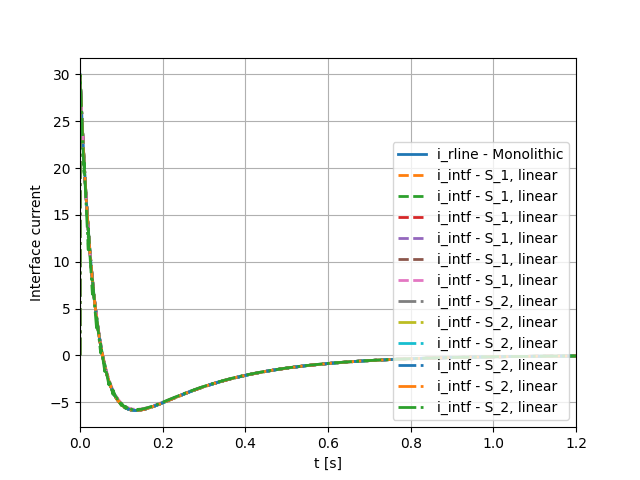

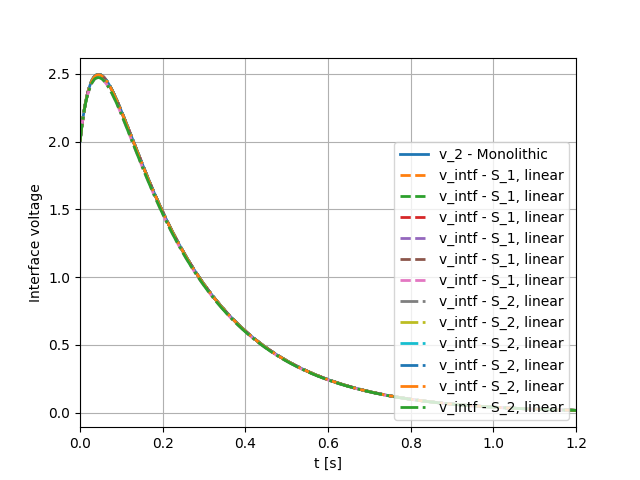

In [4]:
pt.set_timeseries_labels(results_emt['v2'], 'v_2 - Monolithic')
pt.plot_timeseries('Co-simulation results - v_intf - linear', results_emt['v2'])
plt.xlabel('t [s]')
plt.ylabel('Interface voltage')
plt.grid()

pt.set_timeseries_labels(results_emt['r_line.I'], 'i_rline - Monolithic')
pt.plot_timeseries('Co-simulation results - i_intf - linear', results_emt['r_line.I'])

for k, results_att_list in results_emt_attributes_linear_S1.items():
    # pt.set_timeseries_labels(results_att_list['v1'], results_att_list['v1'].label + ' - S_1')
    # pt.plot_timeseries('Co-simulation results - V1', results_att_list['v1'], '--')

    pt.set_timeseries_labels(results_att_list['v_intf'], 'v_intf - S_1, linear')
    pt.plot_timeseries('Co-simulation results - v_intf - linear', results_att_list['v_intf'], '--')

    # pt.set_timeseries_labels(results_att_list['v_ref'], 'v_ref - S_1, linear')
    # pt.plot_timeseries('Co-simulation results - v_intf - linear', results_att_list['v_ref'], '--')
    
    pt.set_timeseries_labels(results_att_list['i_intf'], 'i_intf - S_1, linear')
    pt.plot_timeseries('Co-simulation results - i_intf - linear', results_att_list['i_intf'], '--')

for k, results_att_list in results_emt_attributes_linear_S2.items():
    pt.set_timeseries_labels(results_att_list['v_intf'], 'v_intf - S_2, linear')
    pt.plot_timeseries('Co-simulation results - v_intf - linear', results_att_list['v_intf'], '-.')
    
    pt.set_timeseries_labels(results_att_list['i_intf'], 'i_intf - S_2, linear')
    pt.plot_timeseries('Co-simulation results - i_intf - linear', results_att_list['i_intf'], '-.')

    # pt.set_timeseries_labels(results_att_list['i_ref'], 'i_ref - S_2, linear')
    # pt.plot_timeseries('Co-simulation results - i_intf - linear', results_att_list['i_ref'], '-.')

plt.xlabel('t [s]')
plt.ylabel('Interface current')
plt.grid()
plt.show()


In [5]:
# if num_vs > 0:
#     pt.set_timeseries_labels(results_emt['v0'], 'v_0 - Monolithic')
#     pt.plot_timeseries('Co-simulation results - v_src - no extrap.', results_emt['v0'])

# pt.set_timeseries_labels(results_emt['v1'], 'v_1 - Monolithic')
# pt.plot_timeseries('Co-simulation results - v_intf - no extrap.', results_emt['v1'])
# pt.set_timeseries_labels(results_emt['v2'], 'v_2 - Monolithic')
# pt.plot_timeseries('Co-simulation results - v_intf - no extrap.', results_emt['v2'])
# plt.xlabel('t [s]')
# plt.ylabel('Interface voltage')
# plt.grid()

# pt.set_timeseries_labels(results_emt['r_line.I'], 'i_rline - Monolithic')
# pt.plot_timeseries('Co-simulation results - i_intf - no extrap.', results_emt['r_line.I'])

# for k, results_att_list in results_emt_attributes_no_extrap_S1.items():
#     # pt.set_timeseries_labels(results_att_list['v1'], results_att_list['v1'].label + ' - S_1')
#     # pt.plot_timeseries('Co-simulation results - V1', results_att_list['v1'], '--')

#     pt.set_timeseries_labels(results_att_list['v_intf'], 'v_intf - S_1, no extrap.')
#     pt.plot_timeseries('Co-simulation results - v_intf - no extrap.', results_att_list['v_intf'], '--')

#     # pt.set_timeseries_labels(results_att_list['v_ref'], 'v_ref - S_1, no extrap.')
#     # pt.plot_timeseries('Co-simulation results - v_intf - no extrap.', results_att_list['v_ref'], '--')
    
#     pt.set_timeseries_labels(results_att_list['i_intf'], 'i_intf - S_1, no extrap.')
#     pt.plot_timeseries('Co-simulation results - i_intf - no extrap.', results_att_list['i_intf'], '--')

# for k, results_att_list in results_emt_attributes_no_extrap_S2.items():
#     pt.set_timeseries_labels(results_att_list['v_intf'], 'v_intf - S_2, no extrap.')
#     pt.plot_timeseries('Co-simulation results - v_intf - no extrap.', results_att_list['v_intf'], '-.')
    
#     pt.set_timeseries_labels(results_att_list['i_intf'], 'i_intf - S_2, no extrap.')
#     pt.plot_timeseries('Co-simulation results - i_intf - no extrap.', results_att_list['i_intf'], '-.')

#     # pt.set_timeseries_labels(results_att_list['i_ref'], 'i_ref - S_2, no extrap.')
#     # pt.plot_timeseries('Co-simulation results - i_intf - no extrap.', results_att_list['i_ref'], '-.')

# plt.xlabel('t [s]')
# plt.ylabel('Interface current')
# plt.grid()
# plt.show()


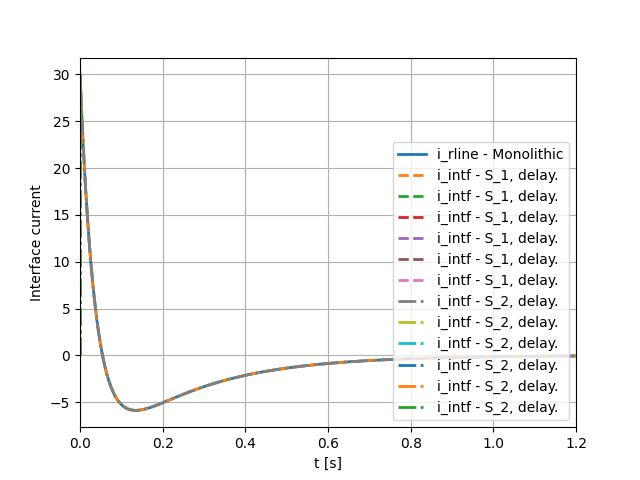

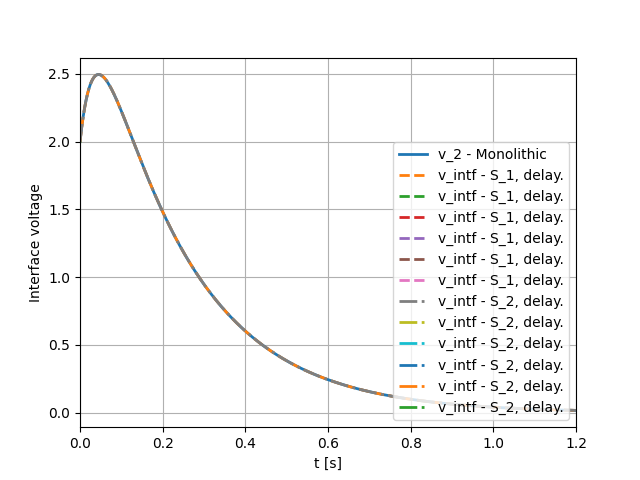

In [6]:
pt.set_timeseries_labels(results_emt['v2'], 'v_2 - Monolithic')
pt.plot_timeseries('Co-simulation results - v_intf - delay.', results_emt['v2'])
plt.xlabel('t [s]')
plt.ylabel('Interface voltage')
plt.grid()

pt.set_timeseries_labels(results_emt['r_line.I'], 'i_rline - Monolithic')
pt.plot_timeseries('Co-simulation results - i_intf - delay.', results_emt['r_line.I'])

for k, results_att_list in results_emt_attributes_delay_S1.items():
    # pt.set_timeseries_labels(results_att_list['v1'], results_att_list['v1'].label + ' - S_1')
    # pt.plot_timeseries('Co-simulation results - V1', results_att_list['v1'], '--')

    pt.set_timeseries_labels(results_att_list['v_intf'], 'v_intf - S_1, delay.')
    pt.plot_timeseries('Co-simulation results - v_intf - delay.', results_att_list['v_intf'], '--')

    # pt.set_timeseries_labels(results_att_list['v_ref'], 'v_ref - S_1, no extrap.')
    # pt.plot_timeseries('Co-simulation results - v_intf - no extrap.', results_att_list['v_ref'], '--')
    
    pt.set_timeseries_labels(results_att_list['i_intf'], 'i_intf - S_1, delay.')
    pt.plot_timeseries('Co-simulation results - i_intf - delay.', results_att_list['i_intf'], '--')

for k, results_att_list in results_emt_attributes_delay_S2.items():
    pt.set_timeseries_labels(results_att_list['v_intf'], 'v_intf - S_2, delay.')
    pt.plot_timeseries('Co-simulation results - v_intf - delay.', results_att_list['v_intf'], '-.')
    
    pt.set_timeseries_labels(results_att_list['i_intf'], 'i_intf - S_2, delay.')
    pt.plot_timeseries('Co-simulation results - i_intf - delay.', results_att_list['i_intf'], '-.')

    # pt.set_timeseries_labels(results_att_list['i_ref'], 'i_ref - S_2, no extrap.')
    # pt.plot_timeseries('Co-simulation results - i_intf - no extrap.', results_att_list['i_ref'], '-.')

plt.xlabel('t [s]')
plt.ylabel('Interface current')
plt.grid()
plt.show()

## Obtain the co-simulation errors

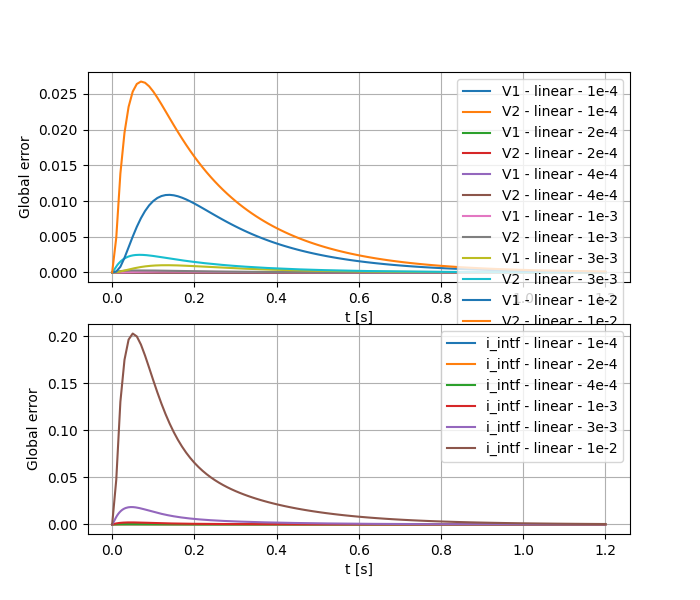

In [17]:
global_error_zoh = []
global_error_linear = []
global_error_delay = []

ts_v1_m = results_emt['v1']
ts_v2_m = results_emt['v2']
ts_i_intf_m = results_emt['r_line.I']

fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(7, 6))

for i in range(0, len(H_v_legends)):    
    H = H_v[i]
    
    m = int(round(H/time_step))

    ts_v1_zoh = results_emt_attributes_zoh_S1[H_v_legends[i]]['v_1']
    ts_v2_zoh = results_emt_attributes_zoh_S1[H_v_legends[i]]['v_2']
    ts_i_intf_zoh = results_emt_attributes_zoh_S1[H_v_legends[i]]['i_intf']
    
    ts_v1_linear = results_emt_attributes_linear_S1[H_v_legends[i]]['v_1']
    ts_v2_linear = results_emt_attributes_linear_S1[H_v_legends[i]]['v_2']
    ts_i_intf_linear = results_emt_attributes_linear_S1[H_v_legends[i]]['i_intf']

    ts_v1_delay = results_emt_attributes_delay_S1[H_v_legends[i]]['v_1']
    ts_v2_delay = results_emt_attributes_delay_S1[H_v_legends[i]]['v_2']
    ts_i_intf_delay = results_emt_attributes_delay_S1[H_v_legends[i]]['i_intf']

    # if num_vs == 0:
    #     ts_1_m = results_emt[1]
    #     ts_2_m = results_emt[2]

    #     ts_1_zoh = results_emt_attributes_zoh[H_v_legends[i]][1]
    #     ts_2_zoh = results_emt_attributes_zoh[H_v_legends[i]][2]
        
    #     ts_1_linear = results_emt_attributes_linear_S1[H_v_legends[i]][1]
    #     ts_2_linear = results_emt_attributes_linear_S1[H_v_legends[i]][2]
    # else:
    #     ts_1_m = results_emt[2]
    #     ts_2_m = results_emt[3]
    
    #     ts_1_zoh = results_emt_attributes_zoh[H_v_legends[i]][2]
    #     ts_2_zoh = results_emt_attributes_zoh[H_v_legends[i]][3]
        
    #     ts_1_linear = results_emt_attributes_linear_S1[H_v_legends[i]][2]
    #     ts_2_linear = results_emt_attributes_linear_S1[H_v_legends[i]][3]
    
    xy_a = np.array([ts_v1_m.values[::m], ts_v2_m.values[::m], ts_i_intf_m.values[::m], ts_v2_m.values[::m]])
    xy_zoh = np.array([ts_v1_zoh.values[::m], ts_v2_zoh.values[::m], ts_i_intf_zoh.values[::m], ts_v2_zoh.values[::m]])
    xy_linear = np.array([ts_v1_linear.values[::m], ts_v2_linear.values[::m], ts_i_intf_linear.values[::m], ts_v2_linear.values[::m]])
    xy_delay = np.array([ts_v1_delay.values[::m], ts_v2_delay.values[::m], ts_i_intf_delay.values[::m], ts_v2_delay.values[::m]])
    
    # global_error_v1_zoh_t = np.abs(ts_v1_m.values[::m] - ts_v1_zoh.values[::m], axis=0)
    # global_error_v2_zoh_t = np.abs(ts_v2_m.values[::m] - ts_v2_zoh.values[::m], axis=0)
    # global_error_i_intf_zoh_t = np.abs(ts_i_intf_m.values[::m] - ts_i_intf_zoh.values[::m], axis=0)

    global_error_v1_linear_t = np.abs(ts_v1_m.values[::m] - ts_v1_linear.values[::m])
    global_error_v2_linear_t = np.abs(ts_v2_m.values[::m] - ts_v2_linear.values[::m])
    global_error_i_intf_linear_t = np.abs(ts_i_intf_m.values[::m] - ts_i_intf_linear.values[::m])

    global_error_v1_delay_t = np.abs(ts_v1_m.values[::m] - ts_v1_delay.values[::m])
    global_error_v2_delay_t = np.abs(ts_v2_m.values[::m] - ts_v2_delay.values[::m])
    global_error_i_intf_delay_t = np.abs(ts_i_intf_m.values[::m] - ts_i_intf_delay.values[::m])
    
    global_error_zoh_t = np.linalg.norm(xy_a - xy_zoh, axis=0)
    global_error_linear_t = np.linalg.norm(xy_a - xy_linear, axis=0)
    global_error_delay_t = np.linalg.norm(xy_a - xy_delay, axis=0)

    # plt.plot(ts_1_m.time[::m], gloal_error_zoh_t, label='ZOH - ' + H_v_legends[i])
    # plt.plot(ts_1_m.time[::m], gloal_error_linear_t, label='linear - ' + H_v_legends[i])

    axes[0].plot(ts_v1_m.time[::m], global_error_v1_linear_t, label='V1 - linear - ' + H_v_legends[i])
    axes[0].plot(ts_v2_m.time[::m], global_error_v2_linear_t, label='V2 - linear - ' + H_v_legends[i])

    axes[1].plot(ts_i_intf_m.time[::m], global_error_i_intf_linear_t, label='i_intf - linear - ' + H_v_legends[i])
    
    global_error_zoh.append(np.max(global_error_zoh_t))
    global_error_linear.append(np.max(np.max(global_error_linear_t)))
    global_error_delay.append(np.max(np.max(global_error_delay_t)))

axes[0].set_xlabel('t [s]')
axes[0].set_ylabel('Global error')
# plt.xlim((0, 0.4))
# plt.ylim((0.0008, 0.0012))
axes[0].grid()
axes[0].legend()

axes[1].set_xlabel('t [s]')
axes[1].set_ylabel('Global error')
# plt.xlim((0, 0.4))
# plt.ylim((0.0008, 0.0012))
axes[1].grid()
axes[1].legend()
    
    

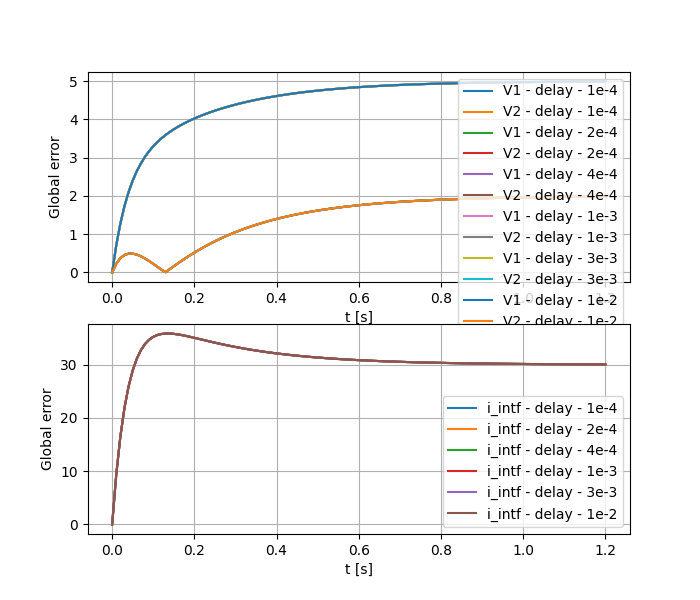

In [19]:
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(7, 6))

for i in range(0, len(H_v_legends)):
    axes[0].plot(ts_v1_m.time[::m], global_error_v1_delay_t, label='V1 - delay - ' + H_v_legends[i])
    axes[0].plot(ts_v2_m.time[::m], global_error_v2_delay_t, label='V2 - delay - ' + H_v_legends[i])

    axes[1].plot(ts_i_intf_m.time[::m], global_error_i_intf_delay_t, label='i_intf - delay - ' + H_v_legends[i])

axes[0].set_xlabel('t [s]')
axes[0].set_ylabel('Global error')
# plt.xlim((0, 0.4))
# plt.ylim((0.0008, 0.0012))
axes[0].grid()
axes[0].legend()

axes[1].set_xlabel('t [s]')
axes[1].set_ylabel('Global error')
# plt.xlim((0, 0.4))
# plt.ylim((0.0008, 0.0012))
axes[1].grid()
axes[1].legend()

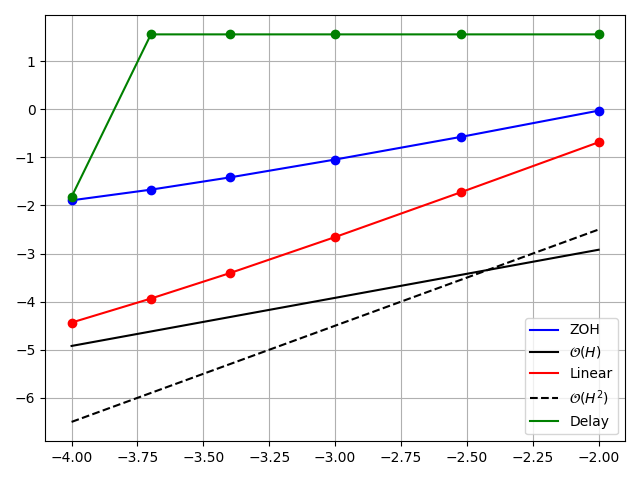

In [16]:
plt.figure()
plt.plot(np.log10(H_v), np.log10(global_error_zoh), 'b', label='ZOH')
plt.plot(np.log10(H_v), np.log10(global_error_zoh), 'bo')
plt.plot(np.log10(H_v), np.log10(np.multiply(H_v, 10*0.012)), 'k', label=r'$\mathcal{O}(H)$')
plt.plot(np.log10(H_v), np.log10(global_error_linear), 'r', label='Linear')
plt.plot(np.log10(H_v), np.log10(global_error_linear), 'ro')
plt.plot(np.log10(H_v), np.log10(np.multiply(H_v**2, 10**1.5)), '--k', label=r'$\mathcal{O}(H^2)$')
plt.plot(np.log10(H_v), np.log10(global_error_delay), 'g', label='Delay')
plt.plot(np.log10(H_v), np.log10(global_error_delay), 'go')
plt.xlabel('')
# TODO: Fix log scale
# plt.xscale("log")
# plt.yscale("log")
plt.grid()
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
!cat logs/EMTCosim.log